# Images from the paper

This notebook intends to generate the images from the paper "On a bivariate beta distribution" from Lucas Moschen and Luiz Carvalho. 

In [8]:
import os
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts/python')
from parameter_estimation import BivariateBeta

plt.style.use('ggplot')

## Plotting the bivariate pdf

This image plots the pdf for different values of $\alpha$.

In [31]:
def plotting_bivariate_beta_pdf(alphas, n_points = 100):
    """
    Plots a grid of 3 x 4 densities of the bivariate beta distribution 
    with parameter alpha.
    
    Parameters:
    | alphas (12 x 4 - array): each line represents a different parameter specification.
    | n_points (int): numper of points to devide each component of the grid.
    """
    x_values = y_values = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.zeros_like(X)

    fig = plt.figure(figsize = (14, 9))

    for k, alpha in tqdm(enumerate(alphas)):
        distribution = BivariateBeta(alpha=alpha)
        for i,x in enumerate(x_values): 
            for j,y in enumerate(y_values): 
                Z[i,j] = distribution.pdf(x, y)
    
        ax = fig.add_subplot(3, 4, k+1, projection='3d') 
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       cmap=sns.color_palette("magma", as_cmap=True), edgecolor='none')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(r"$\alpha =$ {}".format(alpha))
    fig.tight_layout()
    plt.savefig('../figures/joint-densities-bivariate-beta.pdf', bbox_inches = 'tight')

12it [00:40,  3.37s/it]


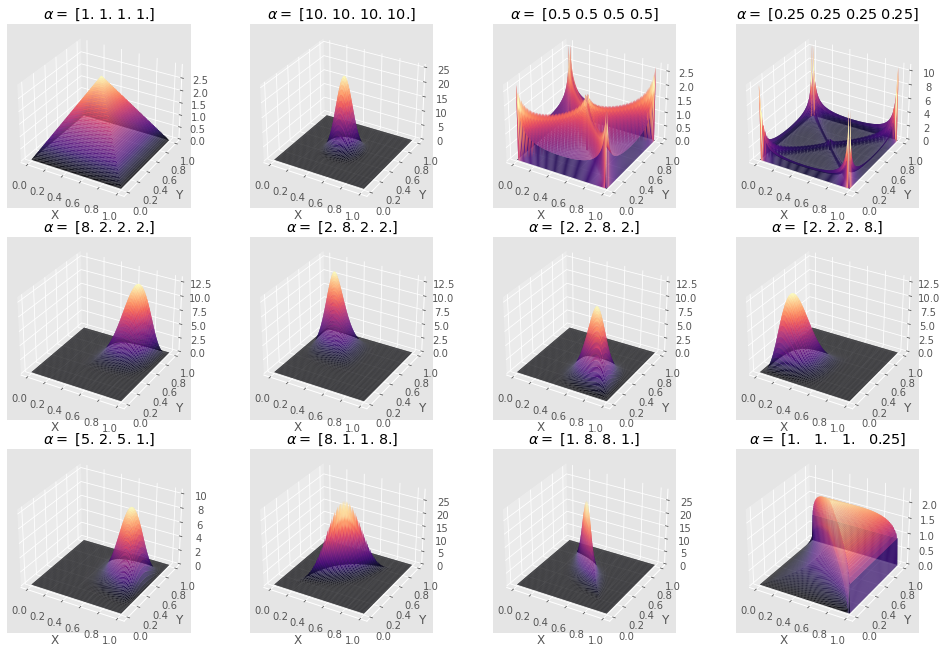

In [33]:
alphas = np.array([[1,1,1,1],
                [10,10,10,10],
                [.5,.5,.5,.5],
                [.25,.25,.25,.25],
                [8,2,2,2],
                [2,8,2,2],
                [2,2,8,2],
                [2,2,2,8],
                [5,2,5,1],
                [8,1,1,8],
                [1,8,8,1],
                [1,1,1,0.25],
                ])

plotting_bivariate_beta_pdf(alphas)
plt.show()

## Representation of the moment sets where there is no bivariate beta

In [44]:
def plotting_positive_sets(v1_list, rho_list, n_points = 1000): 
    """
    Plots the sets where the solution to the system is strictly positive.
    Parameters:
    | v1_list (list): list of values for v1
    | rho_list (list): list of values for rho
    """ 
    distribution = BivariateBeta()
    def z_function(m1, m2, v1, rho):
        return 1*(sum(distribution._system_solution(m1, m2, v1, rho) <= 0) == 0) - 1*(v1 >= m1 - m1*m1)
    m1 = np.linspace(0, 1, n_points, endpoint=False)
    m2 = np.linspace(0, 1, n_points, endpoint=False)

    fig, ax = plt.subplots(3,5,figsize = (16,7), sharex = True, sharey = True)
    colors = ['#8da0cb', '#fc8d62', '#66c2a5']
    for k, (v1, rho) in enumerate(zip(v1_list, rho_list)): 
        i = k // 5
        j = k % 5
        x, y = np.meshgrid(m1,m2)
        data = z_function(x, y, v1, rho)
        ax[i,j].contourf(x, y, data, levels = [-1, -0.1, 0.5, 1], colors = colors )
        ax[i,j].set_title(r'$v_1$ = {} and $\rho$ = {}'.format(v1, rho), fontsize = 12)
        
    for i in range(3): 
        ax[2,i].set_xlabel(r'$m_1$', fontsize = 15)
        ax[i,0].set_ylabel(r'$m_2$', fontsize = 15)
    ax[2,3].set_xlabel(r'$m_1$', fontsize = 15)
    ax[2,4].set_xlabel(r'$m_1$', fontsize = 15)
        
    fig.legend(handles = [mpatches.Patch(color=colors[0], label=r'$v_1 > m_1 - m_1^2$'.format(k+1)),
                          mpatches.Patch(color=colors[1], label=r'$\alpha_i < 0$ for some $i$'.format(k+1)),
                          mpatches.Patch(color=colors[2], label=r'$\alpha_1, \dots, \alpha_4 > 0$'.format(k+1))], 
               loc = 'lower right', fontsize=12)
    plt.savefig('../figures/alpha_solution_existence.pdf', bbox_inches = 'tight')

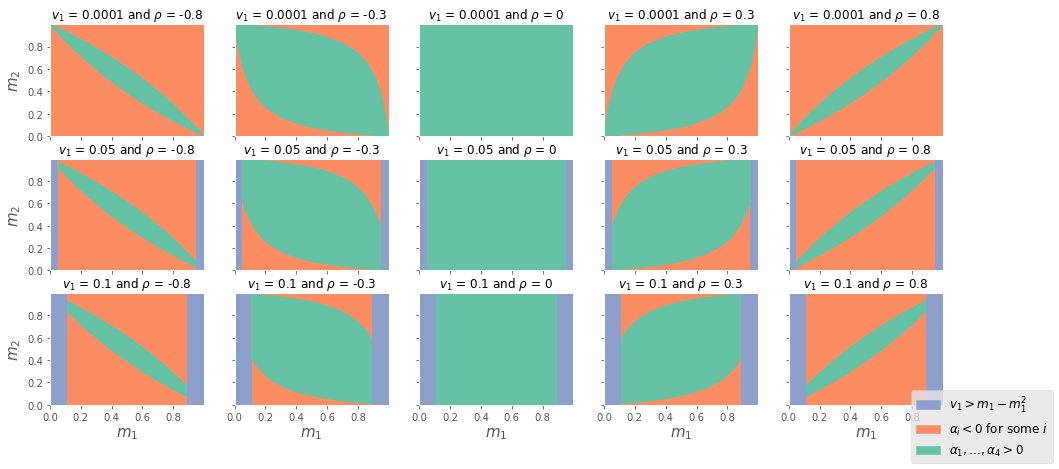

In [45]:
plotting_positive_sets([0.0001]*5 + [0.05]*5 + [0.1]*5, 
                       [-0.8, -0.3, 0, 0.3, 0.8]*4)
plt.show()

In [ ]:
def variation_alpha4(true_alpha, sample_size, monte_carlo_size, seed):
    """
    It does the experiments from Section "Recovering parameters from bivariate beta".
    """
    rng = np.random.default_rng(seed)
    distribution = BivariateBeta()

    moments_vs_alpha4 = np.zeros((monte_carlo_size, 6))

    for k in trange(monte_carlo_size):
        U = rng.dirichlet(true_alpha, size=sample_size)
        X = U[:, 0] + U[:, 1]
        Y = U[:, 0] + U[:, 2]

        alpha_hat1 = distribution.method_moments_estimator_1(X, Y)

        moments_vs_alpha4[k, 0] = X.mean()
        moments_vs_alpha4[k, 1] = Y.mean()
        moments_vs_alpha4[k, 2] = X.var(ddof=1)
        moments_vs_alpha4[k, 3] = Y.var(ddof=1)
        moments_vs_alpha4[k, 4] = np.corrcoef(X,Y)[0,1]
        moments_vs_alpha4[k, 5] = alpha_hat1[2]

    names = [r'$\hat{m}_1$', r'$\hat{m}_2$', r'$\hat{v}_1$', r'$\hat{v}_2$', r'$\hat{\rho}$']

    fig, ax = plt.subplots(1, 5, figsize=(20,4), sharey=True)
    fig.suptitle('Sensitivity analysis', fontsize=20)
    for i in range(5):
        ax[i].scatter(moments_vs_alpha4[:,i], moments_vs_alpha4[:,-1], s=1, color='black')
        ax[i].set_xlabel(names[i], fontsize=14)
    ax[0].set_ylabel(r'$\hat\alpha_4$', fontsize=14)

    plt.savefig(os.path.join(ROOT_DIR, '../../figures/sensibility_analysis_alpha3.pdf'), bbox_inches='tight')
    plt.show()  

In [ ]:
def comparing_methods(true_alpha, monte_carlo_size, bootstrap_size, seed):

    filename1 = starting_experiment(true_alpha, 50, monte_carlo_size, bootstrap_size, seed)
    filename2 = starting_experiment(true_alpha, 1000, monte_carlo_size, bootstrap_size, seed)
    with open(filename1, 'r') as f:
        experiment1 = json.load(f)
    with open(filename2, 'r') as f:
        experiment2 = json.load(f)

    methods = ['MM1', 'MM2', 'MM3', 'MM4']

    bias1 = [np.mean(np.abs(experiment1['bias'][i])) for i in range(4)]
    mape1 = [np.mean(experiment1['mape'][i]) for i in range(4)]
    bias2 = [np.mean(np.abs(experiment2['bias'][i])) for i in range(4)]
    mape2 = [np.mean(experiment2['mape'][i]) for i in range(4)]

    fig, ax = plt.subplots(2,2)

    ax[0,0].bar(methods, mape1, color='black')
    ax[0,1].bar(methods, bias1, color='black')
    ax[1,0].bar(methods, mape2, color='black')
    ax[1,1].bar(methods, bias2, color='black')

    ax[0,0].set_ylabel(r'$n=50$')
    ax[1,0].set_ylabel(r'$n=1000$')
    ax[0,0].set_title('Average MAPE')
    ax[0,1].set_title('Average absolute bias')

    ax[0,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[1,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[0,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[1,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

    fig.tight_layout() 
    plt.savefig(os.path.join(ROOT_DIR, '../../figures/comparing_methods_mape_bias_XXX.pdf'), bbox_inches='tight')
    plt.show()

def comparing_methods2(mu1, mu2, sigma1, sigma2, sample_size, monte_carlo_size, seed):

    filename1 = starting_experiment_2(mu1, sigma1, sample_size, monte_carlo_size, seed)
    filename2 = starting_experiment_2(mu2, sigma2, sample_size, monte_carlo_size, seed)
    with open(filename1, 'r') as f:
        experiment1 = json.load(f)
    with open(filename2, 'r') as f:
        experiment2 = json.load(f)

    values = [r'$m_1$', r'$m_2$', r'$v_1$', r'$v_2$', r'$\rho$']
    mape1 = experiment1['mape'][3]
    mape2 = experiment2['mape'][3]

    fig, ax = plt.subplots(1,2)

    ax[0].bar(values, mape1, color='black')
    ax[1].bar(values, mape2, color='black')

    ax[0].set_ylabel('MAPE')
    ax[0].set_title('Experiment 1')
    ax[1].set_title('Experiment 2')

    # ax[0,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    # ax[1,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    # ax[0,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    # ax[1,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

    fig.tight_layout() 
    #plt.savefig(os.path.join(ROOT_DIR, '../../figures/comparing_methods_mape_bias_XXX.pdf'), bbox_inches='tight')
    plt.show()

def comparing_methods3(mu, sigma, sample_size, monte_carlo_size, seed):

    filename = starting_experiment_2(mu, sigma, sample_size, monte_carlo_size, seed)
    with open(filename, 'r') as f:
        experiment = json.load(f)

    ind = 2*np.arange(6) 
    width = 0.35

    _, ax = plt.subplots()

    for i in range(4):
        ax.bar(ind + i*width, 
               np.hstack([experiment['bias'][i], np.mean(experiment['bias'][i])]), 
               width=width)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('E[X]', 'E[Y]', 'Var(X)', 'Var(Y)', 'Cor(X,Y)', 'Average'))
    ax.set_title('Bias estimate of the methods for the moments')
    plt.savefig(os.path.join(ROOT_DIR, '../../figures/bias_estimate_moments_logit_normal.pdf'), bbox_inches='tight')
    plt.show()

def comparing_exec_times(true_alpha, monte_carlo_size, bootstrap_size, seed):

    filename = starting_experiment(true_alpha, 50, monte_carlo_size, bootstrap_size, seed)
    with open(filename, 'r') as f:
        experiment = json.load(f)

    methods = ['MM1', 'MM2', 'MM3', 'MM4']
    plt.bar(methods, experiment['comp'][:-1], color='black')
    plt.ylabel('Time (s)')
    plt.title('Comparing estimation runtime', fontsize=16)
    plt.savefig(os.path.join(ROOT_DIR, '../../figures/runtime_moments_methods.pdf'), bbox_inches='tight')
    plt.show()


In [ ]:
def bootstrap_plot():
    
    true_alpha = np.array([2,4,3,1])
    ro = np.random.default_rng(np.random.randint(31829))
    distribution = BivariateBeta()
    sample_sizes = [10, 20, 50, 100, 200, 1000]
    bootstrap_samples = list(range(50, 5000, 50))
    ci_alpha1 = np.zeros((2, len(bootstrap_samples)))

    fig, ax = plt.subplots(2, 3)

    for ind, sample_size in tqdm(enumerate(sample_sizes)):
        i = ind // 3
        j = ind % 3
        U = ro.dirichlet(true_alpha, size=sample_size)
        X = U[:, 0] + U[:, 1]
        Y = U[:, 0] + U[:, 2]
        for b in bootstrap_samples:
            samples = distribution.bootstrap_method(X, Y, B=b, method=distribution.method_moments_estimator_1, processes=4)
            ci_alpha1[:, (b-50)//50] = distribution.confidence_interval(level=0.95, samples=samples)[:, 0]
        ax[i,j].plot(bootstrap_samples, ci_alpha1[0])
        ax[i,j].plot(bootstrap_samples, ci_alpha1[1])
        ax[i,j].set_title('n={}'.format(sample_size))
    plt.show()

def sensibility_plot():

    true_alpha = np.array([1,1,1,1])
    n=1000
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    m1 = X.mean()
    m2 = Y.mean()
    v1 = X.var(ddof=1)
    v2 = Y.var(ddof=1)
    rho = np.corrcoef(X,Y)[0,1]

    distribution = BivariateBeta()
    alpha1, alpha2 = np.meshgrid(np.linspace(1e-1, 2, 100), np.linspace(1e-1, 2, 100))
    v = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            true_alpha = np.array([alpha1[i,j], alpha2[i,j], 1, 1])
            v[i,j] = distribution.loss_function(alpha=true_alpha, m1=m1, m2=m2, v1=v1, v2=v2, rho=rho, g=distribution._choose_loss_function())
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(alpha1, alpha2, v)
    fig.colorbar(cp)
    plt.show()